In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
seed = 42

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.1
torch 2.6.0+cpu
cpu


# 准备数据

In [84]:
from tensorflow import keras  #这里的波浪线不用管

#用karas有的数据集imdb，电影分类,分电影是积极的，还是消极的
imdb = keras.datasets.imdb
#载入数据使用下面两个参数
vocab_size = 10000  #词典大小，仅保留训练数据中前10000个最经常出现的单词，低频单词被舍弃
index_from = 3  #0,1,2,3空出来做别的事
#前一万个词出现词频最高的会保留下来进行处理，后面的作为特殊字符处理，
# 小于3的id都是特殊字符，下面代码有写
# 需要注意的一点是取出来的词表还是从1开始的，需要做处理
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from=index_from)

In [85]:
type(train_labels)

numpy.ndarray

In [86]:
print(type(train_data))

<class 'numpy.ndarray'>


In [87]:
train_data.shape  #每个样本是一段话，每个单词用一个数字表示

(25000,)

In [88]:
type(train_data[0])

list

In [89]:
train_data[2]

[1,
 14,
 47,
 8,
 30,
 31,
 7,
 4,
 249,
 108,
 7,
 4,
 5974,
 54,
 61,
 369,
 13,
 71,
 149,
 14,
 22,
 112,
 4,
 2401,
 311,
 12,
 16,
 3711,
 33,
 75,
 43,
 1829,
 296,
 4,
 86,
 320,
 35,
 534,
 19,
 263,
 4821,
 1301,
 4,
 1873,
 33,
 89,
 78,
 12,
 66,
 16,
 4,
 360,
 7,
 4,
 58,
 316,
 334,
 11,
 4,
 1716,
 43,
 645,
 662,
 8,
 257,
 85,
 1200,
 42,
 1228,
 2578,
 83,
 68,
 3912,
 15,
 36,
 165,
 1539,
 278,
 36,
 69,
 2,
 780,
 8,
 106,
 14,
 6905,
 1338,
 18,
 6,
 22,
 12,
 215,
 28,
 610,
 40,
 6,
 87,
 326,
 23,
 2300,
 21,
 23,
 22,
 12,
 272,
 40,
 57,
 31,
 11,
 4,
 22,
 47,
 6,
 2307,
 51,
 9,
 170,
 23,
 595,
 116,
 595,
 1352,
 13,
 191,
 79,
 638,
 89,
 2,
 14,
 9,
 8,
 106,
 607,
 624,
 35,
 534,
 6,
 227,
 7,
 129,
 113]

In [90]:
len(train_data[0])

218

In [91]:
len(train_data[1])

189

In [92]:
train_labels[0:10]  #二分类

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 0])

In [93]:
print("train", len(train_data), train_labels.shape)  #25000个样本，每个样本是一段话，每个单词用一个数字表示
print("test", len(test_data), test_labels.shape)

train 25000 (25000,)
test 25000 (25000,)


In [94]:
#载入词表，看下词表长度，词表就像英语字典
word_index = imdb.get_word_index()
print(len(word_index))
print(type(word_index))
#词表虽然有8万多，但是我们只载入了最高频的1万词！！！！

88584
<class 'dict'>


## 构造 word2idx 和 idx2word

In [95]:
word2idx = {word: idx + 3 for word, idx in word_index.items()}  # 0,1,2,3空出来做别的事,这里的idx是从1开始的,所以加3
word2idx.update({
    "[PAD]": 0,  # 填充 token
    "[BOS]": 1,  # begin of sentence
    "[UNK]": 2,  # 未知 token
    "[EOS]": 3,  # end of sentence
})
idx2word = {idx: word for word, idx in word2idx.items()}  # 反向词典,id变为单词

In [96]:
print(word2idx["world"])

182


In [97]:
idx2word[4]

'the'

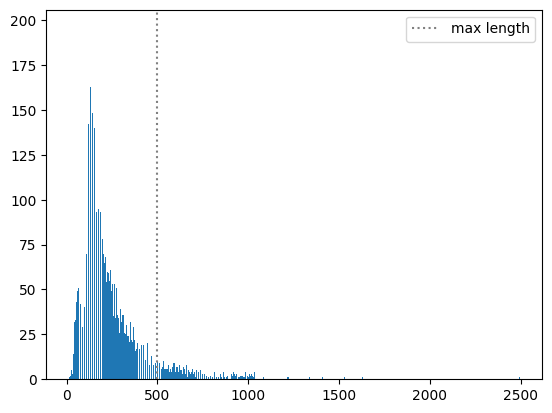

In [98]:
# 选择 max_length
length_collect = {}
#统计样本中每个长度出现的次数
for text in train_data:
    length = len(text)  #句子长度
    length_collect[length] = length_collect.get(length, 0) + 1  #统计长度的频率

MAX_LENGTH = 500
plt.bar(length_collect.keys(), length_collect.values())  #长度分布图
plt.axvline(MAX_LENGTH, label="max length", c="gray", ls=":")  #画一条线，可以看到大部分都在500以内
plt.legend()
plt.show()

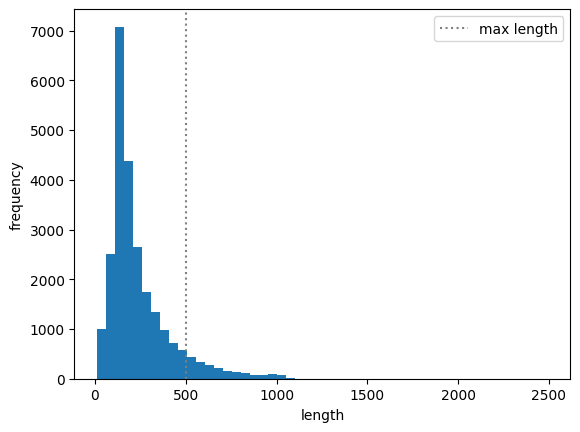

In [99]:
#想对句子长度画个直方图，看看长度分布
length_list = [len(text) for text in train_data]
plt.hist(length_list, bins=50)
plt.xlabel("length")
plt.ylabel("frequency")
plt.axvline(500, label="max length", c="gray", ls=":") 
plt.legend()
plt.show()

In [100]:
length_list[0:10]

[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]

In [101]:
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
raw_text

[['hello', 'world'],
 ['tokenize', 'text', 'datas', 'with', 'batch'],
 ['this', 'is', 'a', 'test']]

## Tokenizer

In [102]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx  #词表,单词到id
        self.idx2word = idx2word  #词表，id到单词
        self.max_length = max_length
        self.pad_idx = pad_idx  #填充
        self.bos_idx = bos_idx  #开始
        self.eos_idx = eos_idx  #结束
        self.unk_idx = unk_idx  #未知，未出现在最高频词表中的词

    def encode(self, text_list):
        """
        将文本列表转化为索引列表
        :param text_list:当前批次的文本列表
        :return:
        """
        max_length = min(self.max_length, 2 + max(
            [len(text) for text in text_list]))  #最大长度，最大长度是500，但是如果句子长度小于500，就取句子长度（句子长度是本组句子中最长的），2是为了留出开始和结束的位置
        indices = []
        for text in text_list:
            index = [self.word2idx.get(word, self.unk_idx) for word in text]  #单词转化为id，未知的词用unk_idx代替
            index = [self.bos_idx] + index + [self.eos_idx]  #添加开始和结束
            if len(index) < max_length:
                index = index + [self.pad_idx] * (max_length - len(index))  #填充0
            else:
                index = index[:max_length]  #如果句子长度大于500，就截断
            indices.append(index)
        return torch.tensor(indices)  #二维列表转化为tensor

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        将索引列表转化为文本列表
        :param indices_list:某批次的索引列表
        :param remove_bos:
        :param remove_eos:
        :param remove_pad:
        :param split:
        :return:
        """
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                word = self.idx2word.get(index, "[UNK]")
                if remove_bos and word == "[BOS]":
                    continue
                if remove_eos and word == "[EOS]":
                    break
                if remove_pad and word == "[PAD]":
                    break
                text.append(word)
            text_list.append(" ".join(text) if not split else text)
        return text_list


tokenizer = Tokenizer(word2idx=word2idx, idx2word=idx2word)
raw_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices = tokenizer.encode(raw_text)  #encode支持批量处理
print("raw text")
for raw in raw_text:
    print(raw)
print("indices")
for index in indices:
    print(index)

raw text
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
indices
tensor([   1, 4825,  182,    3,    0,    0,    0])
tensor([    1,     2,  3004,     2,    19, 19233,     3])
tensor([   1,   14,    9,    6, 2181,    3,    0])


In [103]:
decode_text = tokenizer.decode(indices.tolist(), remove_bos=False, remove_eos=False, remove_pad=False)
print("---------decode text----------")
for decode in decode_text:
    print(decode)

---------decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with batch [EOS]
[BOS] this is a test [EOS] [PAD]


In [104]:
train_data[0:1]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])],
      dtype=object)

In [105]:
# 看看训练集的数据
tokenizer.decode(train_data[0:1], remove_bos=False, remove_eos=False, remove_pad=False)

["[BOS] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [UNK] is an amazing actor and now the same being director [UNK] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [UNK] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [UNK] to the two little boy's that played the [UNK] of norman and paul they were just brilliant children are often left out of the [UNK] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

## 数据集与 DataLoader

In [106]:
from torch.utils.data import Dataset, DataLoader
import torch

# 自定义IMDB数据集类，继承自PyTorch的Dataset类
class IMDBDataset(Dataset):
    def __init__(self, data, labels, remain_length=True):
        """
        初始化IMDB数据集
        :param data: 文本数据，通常是经过预处理的token IDs
        :param labels: 对应的标签数据
        :param remain_length: 是否保留特殊标记（如BOS, EOS, PAD），默认为True
        """
        if remain_length:  # 如果保留特殊标记
            # 使用tokenizer将token IDs解码为文本，保留BOS、EOS和PAD标记
            self.data = tokenizer.decode(data, remove_bos=False, remove_eos=False, remove_pad=False)
        else:
            # 如果不保留特殊标记，直接解码为文本
            self.data = tokenizer.decode(data)
        self.labels = labels  # 存储标签数据

    def __getitem__(self, index):
        """
        获取数据集中的单个样本
        :param index: 样本的索引
        :return: 返回文本和对应的标签
        """
        text = self.data[index]  # 获取索引对应的文本
        label = self.labels[index]  # 获取索引对应的标签
        return text, label

    def __len__(self):
        """
        返回数据集的大小
        :return: 数据集中的样本数量
        """
        return len(self.data)


def collate_fct(batch):
    """
    自定义collate函数，用于将batch数据转换为tensor形式
    :param batch: 一个batch的数据，包含多个样本
    :return: 返回处理后的文本和标签的tensor
    """
    # 将batch中的文本数据分割成单词列表
    text_list = [item[0].split() for item in batch]  # batch是128个样本，每个样本是一个元组，第一个元素是文本，第二个元素是标签
    # 提取batch中的标签数据
    label_list = [item[1] for item in batch]
    # 使用tokenizer将文本列表编码为token IDs，并转换为tensor
    text_list = tokenizer.encode(text_list).to(dtype=torch.int)
    # 将标签列表转换为tensor，并调整形状为(batch_size, 1)
    return text_list, torch.tensor(label_list).reshape(-1, 1).to(dtype=torch.float)

# 创建训练和测试数据集实例
train_ds = IMDBDataset(train_data, train_labels)
test_ds = IMDBDataset(test_data, test_labels)

In [107]:
# 设置批量大小
batch_size = 128

# 创建训练数据加载器
train_dl = DataLoader(
    train_ds,  # 训练数据集
    batch_size=batch_size,  # 每个批次的样本数量
    shuffle=True,  # 是否在每个epoch开始时打乱数据
    collate_fn=collate_fct  # 自定义的collate函数，用于处理batch数据
)

# 创建测试数据加载器
test_dl = DataLoader(
    test_ds,  # 测试数据集
    batch_size=batch_size,  # 每个批次的样本数量
    shuffle=False,  # 测试数据不需要打乱
    collate_fn=collate_fct  # 自定义的collate函数，用于处理batch数据
)

In [108]:
# 要看到每个batch的长度不同，需要修改batch_size为12
# 每个批次128个样本，样本最大长度为500
i=0
for text, label in train_dl:
    print(text.shape, label.shape)
    i+=1
    if i==50:
        break

torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Size([128, 1])
torch.Size([128, 500]) torch.Siz

# 定义模型

In [109]:
(128,500,10000)

(128, 500, 10000)

In [110]:
train_data[0:1]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])],
      dtype=object)

In [111]:
m = nn.AdaptiveAvgPool1d(1)  # 自适应平均池化，目标输出大小为1
input = torch.randn(1, 3, 9)  # 创建一个随机张量，形状为(1, 3, 9)
output = m(input)  # 应用自适应平均池化
output.size()  # 获取输出张量的形状

torch.Size([1, 3, 1])

In [112]:
import torch
import torch.nn as nn
import numpy as np

class AddingModel(nn.Module):
    def __init__(self, embedding_dim=16, hidden_dim=64, vocab_size=10000):
        super(AddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # 词嵌入层，将词汇索引映射为密集向量
        self.pool = nn.AdaptiveAvgPool1d(1)  # 自适应平均池化层，将序列的每个特征维度平均池化到固定长度
        self.layer = nn.Linear(embedding_dim, hidden_dim)  # 全连接层，将嵌入向量转换为隐藏层表示
        self.fc = nn.Linear(hidden_dim, 1)  # 全连接层，将隐藏层表示转换为最终输出

    def forward(self, x):
        # x: [batch_size, seq_length] 例如 [128, 500]
        # 变换过程：对于一个样本，先把一个样本变成onehot编码(10000为词汇表), 再乘一个超参矩阵，生成密集向量：[1, 500] -> [500, 10000] * [10000, 16] -> [500, 16]
        # 将输入的词汇索引转换为密集向量，输出形状: [batch_size, seq_length, embedding_dim] 例如 [128, 500, 16]
        x = self.embedding(x)
        
        # 调整张量的维度，以便在序列长度上进行池化，输出形状: [batch_size, embedding_dim, seq_length] 例如 [128, 16, 500]
        x = x.permute(0, 2, 1)
        
        # 应用自适应平均池化，每个样本变为一个固定长度的向量，输出形状: [batch_size, embedding_dim, 1] 例如 [128, 16, 1]
        # 对一个样本的500个词进行池化求平均
        x = self.pool(x)
        
        # 去掉长度为1的维度，输出形状: [batch_size, embedding_dim] 例如 [128, 16]
        x = x.squeeze(2)
        
        # 通过全连接层将嵌入向量转换为隐藏层表示，输出形状: [batch_size, hidden_dim] 例如 [128, 64]
        x = self.layer(x)
        
        # 通过全连接层将隐藏层表示转换为最终输出，输出形状: [batch_size, 1] 例如 [128, 1]
        x = self.fc(x)

        return x

# 实例化模型
model = AddingModel()
# 遍历模型的所有参数，打印参数的名称和参数数量
for key, value in model.named_parameters():
    print(f"{key:^40} parameters num: {np.prod(value.shape)}")

            embedding.weight             parameters num: 160000
              layer.weight               parameters num: 1024
               layer.bias                parameters num: 64
               fc.weight                 parameters num: 64
                fc.bias                  parameters num: 1


In [113]:
16 * 64

1024

# 训练

In [114]:
from sklearn.metrics import accuracy_score
import torch
import numpy as np

# 确保在评估过程中不会计算梯度
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []  # 用于存储每个批次的损失值
    pred_list = []  # 用于存储预测结果
    label_list = []  # 用于存储真实标签

    # 遍历数据加载器中的每个批次
    for datas, labels in dataloader:
        datas = datas.to(device)  # 将数据移动到指定设备（如GPU）
        labels = labels.to(device)  # 将标签移动到指定设备

        # 前向计算，获取模型输出
        logits = model(datas)
        # 计算当前批次的损失
        loss = loss_fct(logits, labels)
        # 将损失值添加到列表中
        loss_list.append(loss.item())

        # 对于二分类问题，将输出概率转换为布尔值（True或False）
        preds = logits > 0
        # 将预测结果和标签转换为列表，并存储起来
        pred_list.extend(preds.cpu().numpy().tolist())
        label_list.extend(labels.cpu().numpy().tolist())

    # 计算所有批次的平均损失
    avg_loss = np.mean(loss_list)
    # 使用sklearn的accuracy_score函数计算准确率
    acc = accuracy_score(label_list, pred_list)

    return avg_loss, acc

### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [115]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [116]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))

### Early Stop

In [117]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [118]:
# 训练函数
def training(
        model,  # 模型对象
        train_loader,  # 训练数据加载器
        val_loader,  # 验证数据加载器
        epoch,  # 训练的总轮数
        loss_fct,  # 损失函数
        optimizer,  # 优化器
        tensorboard_callback=None,  # TensorBoard回调函数，用于可视化训练过程
        save_ckpt_callback=None,  # 保存模型检查点的回调函数
        early_stop_callback=None,  # 早停回调函数，用于在验证集上性能不再提升时提前停止训练
        eval_step=500,  # 每隔多少步进行一次验证
):
    # 记录训练和验证过程中的损失和准确率
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0  # 全局步数，用于记录训练的总步数
    model.train()  # 将模型设置为训练模式
    with tqdm(total=epoch * len(train_loader)) as pbar:  # 使用tqdm显示训练进度条
        for epoch_id in range(epoch):  # 遍历每个epoch
            # training
            for datas, labels in train_loader:  # 遍历训练数据
                datas = datas.to(device)  # 将数据移动到指定设备（如GPU）
                labels = labels.to(device)  # 将标签移动到指定设备
                # 梯度清空
                optimizer.zero_grad()  # 清空优化器的梯度
                # 模型前向计算
                logits = model(datas)  # 模型前向传播，得到输出logits
                # 计算损失
                loss = loss_fct(logits, labels)  # 计算损失
                # 梯度回传
                loss.backward()  # 反向传播，计算梯度
                # 调整优化器，包括学习率的变动等
                optimizer.step()  # 更新模型参数
                preds = logits > 0  # 当sigmoid输出大于0.5时，预测为1，否则预测为0

                # 计算准确率
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                loss = loss.cpu().item()  # 将损失从GPU移动到CPU并转换为Python数值
                # 记录训练结果
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:  # 每隔eval_step步进行一次验证
                    model.eval()  # 将模型设置为评估模式
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)  # 在验证集上评估模型
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()  # 将模型重新设置为训练模式

                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],  # 当前学习率
                        )

                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:  # 如果满足早停条件
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict  # 提前结束训练

                # 更新步数
                global_step += 1
                pbar.update(1)  # 更新进度条
                pbar.set_postfix({"epoch": epoch_id})  # 显示当前epoch

    return record_dict  # 返回训练和验证的记录


# 训练参数设置
epoch = 20  # 训练的总轮数

model = AddingModel()  # 实例化模型

# 1. 定义损失函数 采用二进制交叉熵损失, 先sigmoid再计算交叉熵
loss_fct = F.binary_cross_entropy_with_logits
# loss_fct =nn.BCEWithLogitsLoss()

# 2. 定义优化器 采用 Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/imdb-adding")
# tensorboard_callback.draw_model(model, [1, MAX_LENGTH])

# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/imdb-adding", save_step=len(train_dl), save_best_only=True)

# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)  # 设置早停的耐心值为5

# 将模型移动到指定设备（如GPU）
model = model.to(device)

# 开始训练
record = training(
    model,
    train_dl,  # 训练数据加载器
    test_dl,  # 验证数据加载器
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=tensorboard_callback,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)  # 每隔一个epoch进行一次验证
)

  0%|          | 0/3920 [00:00<?, ?it/s]

Early stop at epoch 15 / global_step 2940


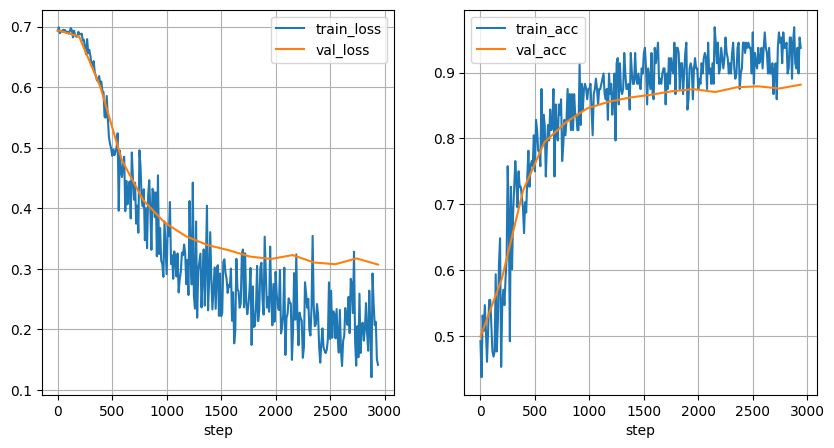

In [119]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")

    plt.show()
plot_learning_curves(record, sample_step=10)  #横坐标是 steps

# 评估

In [120]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/imdb-adding/best.ckpt", weights_only=True,map_location="cpu"))

model.eval()
loss, acc = evaluating(model, test_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3070
accuracy: 0.8816
